<h1><b><span style="color: #e56b6f; font-size: 28px">TABLE OF CONTENTS</span></b></h1>

* [Overview](#0)
* [Importing Libraries](#1)
* [Loading Dataset](#2)
* [Data Visualization](#3)
* [Text Preprocessing](#4)
* [Building Model with Sklearn](#5)
* [Building Model with Tensorflow](#6)
* [Prediction](#7)

<a id="0"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">OVERVIEW</span></b></h1>

In this notebook, we are going to do semantic analysis on hotel reviews from Tripadvisor. We will 2 different approaches:
1. With machine learning models using sklearn
2. With deep neural network using tensorflow

There are also some text preprocessing before we train our model to make sure that our data is clean. At the end of this notebook, we will try to predict the sentiment of our own review

**So, let's dive into the code!**

<a id="1"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">IMPORTING LIBRARIES</span></b></h1>

In [ ]:
# nltk is one of the most useful libraries when it comes to nlp
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

<a id="1"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">LOADING DATASET</span></b></h1>

In [ ]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/TripAdvisor_SentimentAnalysis.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
df = pd.read_csv("/content/tripadvisor_hotel_reviews.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


As you can see from above details, there is **no null values** in this dataset

<a id="3"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">DATA VISUALIZATION</span></b></h1>

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

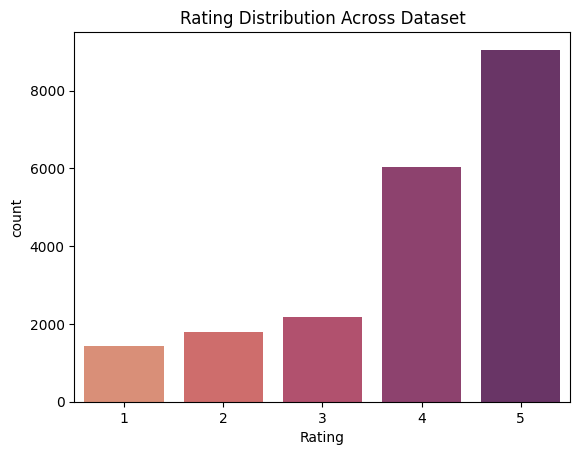

In [ ]:
sns.countplot(data=df, x='Rating', palette='flare').set_title('Rating Distribution Across Dataset')

In [ ]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


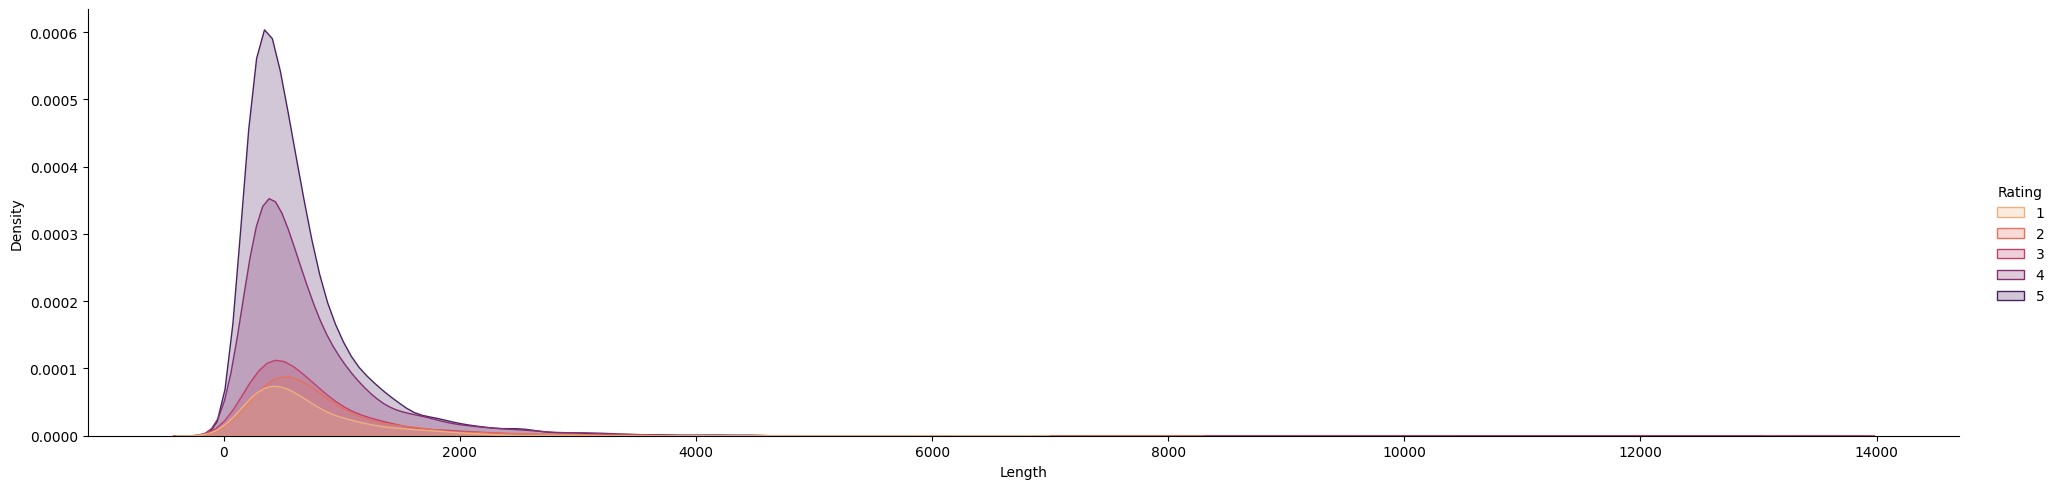

In [ ]:
sns.displot(data=df, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

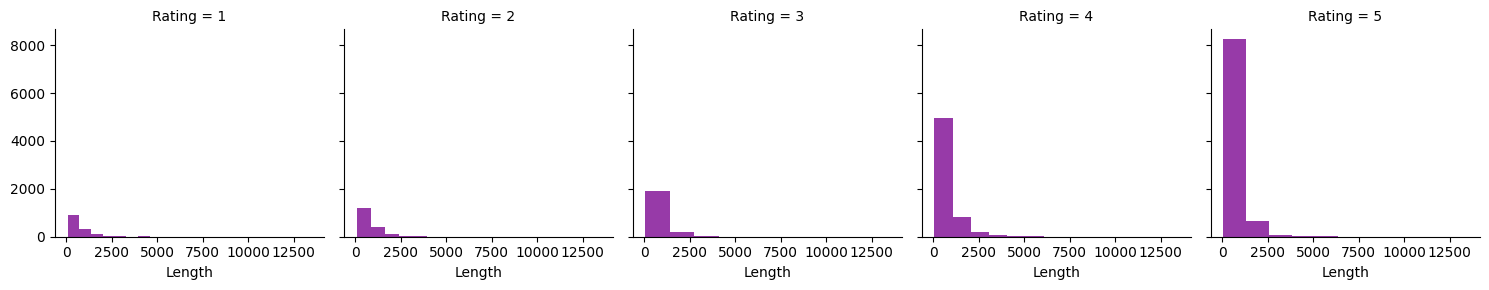

In [ ]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#973aa8')

<ipython-input-15-bfb0fb9b3000>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x='Rating', y='Length', palette='flare', alpha=0.3)


<Axes: xlabel='Rating', ylabel='Length'>

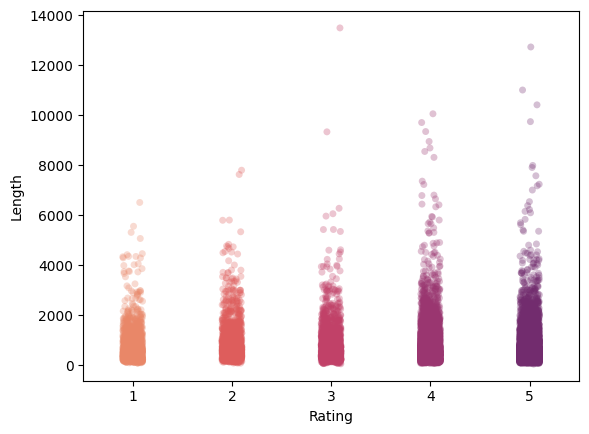

In [ ]:
sns.stripplot(data=df, x='Rating', y='Length', palette='flare', alpha=0.3)

From above plot we can say that **the higher the rating of the hotel, the more likely the visitors wrote a long review**

<a id="4"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">TEXT PREPROCESSING</span></b></h1>

In [ ]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [ ]:
df['Rating'] = df['Rating'].apply(rating)

In [ ]:
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Good,593
1,ok nothing special charge diamond member hilto...,Bad,1689
2,nice rooms not 4* experience hotel monaco seat...,Netral,1427
3,"unique, great stay, wonderful time hotel monac...",Good,600
4,"great stay great stay, went seahawk game aweso...",Good,1281


In [ ]:
# Total word in dataset before cleaning
length = df['Length'].sum()

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Stemming vs Lemmatization</b></h1>

I think this picture can give you a sense of what is the different between stemming and lemmatization

![image](https://stringfixer.com/files/107654628.jpg)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

There are some difference among those 3 sentences, for instance:
* Original -> got, arrived
* Stemming -> got, arriv
* Lemmatization -> get, arrive

This time, we will use Lemmatization in order to get the base form of the word

In [ ]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [ ]:
df['Review'] = df['Review'].apply(cleaning)

In [ ]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 14853861
Total text length after cleaning: 13543965


In [ ]:
df.to_csv('cleaned_df.csv', index=False)

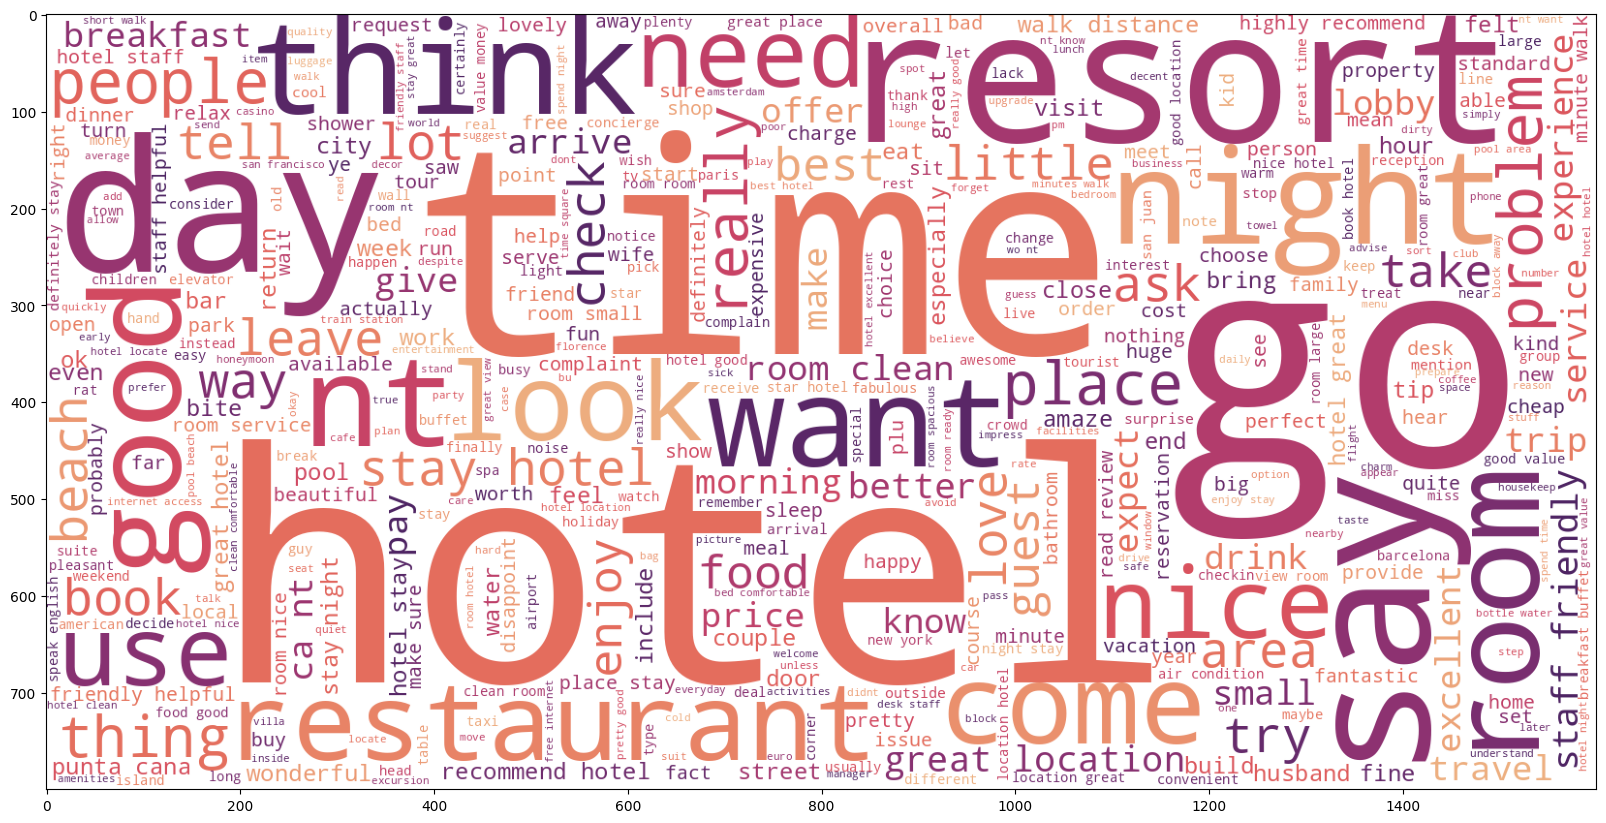

In [ ]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['Review']))

plt.imshow(wc)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">BUILDING MODEL WITH SKLEARN</span></b></h1>

In [ ]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [ ]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

In [ ]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [ ]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

In [ ]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

Since Logistic Regression performs better than other models in this case, we will use it to train our model

In [ ]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [ ]:
pickle.dump(log, open('ml_model.pkl', 'wb'))

In [ ]:
ml = pickle.load(open('ml_model.pkl','rb'))
tfidf = pickle.load(open('tfidf.pkl','rb'))
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfidf.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]
    
    return pred, pred_proba[0][idx]

ml_predict('poor room service')

In [ ]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

<a id="6"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">BUILDING MODEL WITH TENSORFLOW</span></b></h1>

In [ ]:
X_train

15403    park hotel get nod pink glass say comprehensiv...
15588    felt home stay february 2 nights valley wing s...
7960     wow expect season yes service great hotel imma...
8370     fantastic roof pool terrace stay fact were wr...
12864    great locationlovely staff stay hotel 2 nights...
                               ...                        
1344     class stay waikiki parc twice afford hotel hig...
2362     perfect way try new york couple time year shop...
14900    central central 5 minutes walk las ramblas vib...
5887     elegant friendly comfortable stay sofitel marc...
20059    fair away caribbean 10 years bring children 13...
Name: Review, Length: 16392, dtype: object

In [ ]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 64701


In [ ]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                                                          bias_regularizer=l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           517608    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               3200      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                        

In [ ]:
train_padded.shape, train_labels.shape

((16392, 1887), (16392, 3, 2))

In [ ]:
total_word

64701

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
513/513 [==============================] - 149s 270ms/step - loss: 0.9426 - accuracy: 0.7008 - val_loss: 0.7764 - val_accuracy: 0.7370
Epoch 2/25
513/513 [==============================] - 80s 156ms/step - loss: 0.8364 - accuracy: 0.7294 - val_loss: 0.7323 - val_accuracy: 0.7370
Epoch 3/25
513/513 [==============================] - 66s 129ms/step - loss: 0.7517 - accuracy: 0.7347 - val_loss: 0.6294 - val_accuracy: 0.7370
Epoch 4/25
513/513 [==============================] - 55s 106ms/step - loss: 0.6642 - accuracy: 0.7362 - val_loss: 0.5567 - val_accuracy: 0.7370
Epoch 5/25
513/513 [==============================] - 53s 104ms/step - loss: 0.5968 - accuracy: 0.7364 - val_loss: 0.5459 - val_accuracy: 0.7370
Epoch 6/25
513/513 [==============================] - 49s 96ms/step - loss: 0.5601 - accuracy: 0.7364 - val_loss: 0.5313 - val_accuracy: 0.7370
Epoch 7/25
513/513 [==============================] - 53s 103ms/step - loss: 0.5398 - accuracy: 0.7363 - val_loss: 0.6246 - val_ac

<Axes: >

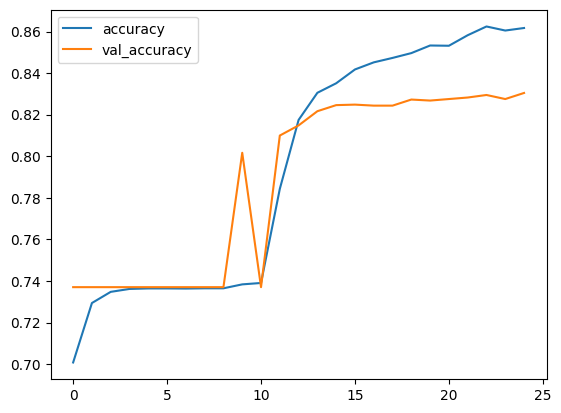

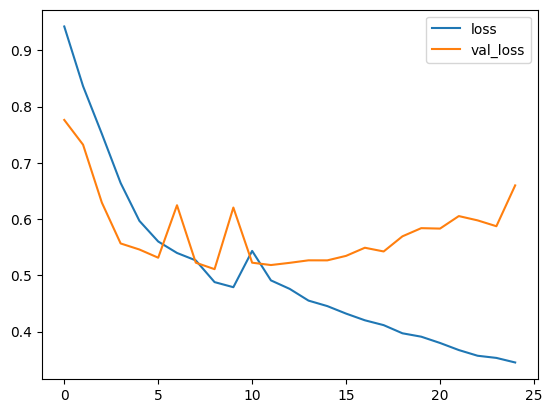

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [ ]:
pred2 = model.predict(test_padded)

129/129 [==============================] - 4s 27ms/step


In [ ]:
true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred2, axis=-1)

In [ ]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[ 518  129    0]
 [ 135 2886    0]
 [ 192  239    0]]
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       647
           1       0.89      0.96      0.92      3021
           2       0.00      0.00      0.00       431

    accuracy                           0.83      4099
   macro avg       0.50      0.59      0.54      4099
weighted avg       0.75      0.83      0.79      4099



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('dl_model.h5')

<a id="7"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">PREDICTION</span></b></h1>

Let's make some prediction using the model we have trained. You can create your own reviews and let the model predict the sentiment in your text

In [ ]:
# # Logistic Regression
# def ml_predict(text):
#     clean_text = cleaning(text)
#     tfid_matrix = tfid.transform([clean_text])
#     pred = log.predict(tfid_matrix)[0]
    
#     return pred

# Deep Neural Network
def dl_predict(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [ ]:
text = 'Such a comfy place to stay with the loved one'

# print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))
print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 [==============================] - 1s 620ms/step
Prediction using DNN: Good


In [ ]:
text2 = 'Awful room services and slow wifi connection'

# print('Prediction using Logistic Regression: {}'.format(ml_predict(text2)))
print('Prediction using DNN: {}'.format(dl_predict(text2)))

1/1 [==============================] - 0s 27ms/step
Prediction using DNN: Bad


In [ ]:
text3 = 'Hard to get here but the scenery is wonderful'

# print('Prediction using Logistic Regression: {}'.format(ml_predict(text3)))
print('Prediction using DNN: {}'.format(dl_predict(text3)))

1/1 [==============================] - 0s 19ms/step
Prediction using DNN: Bad


In [ ]:
!pip install nltk

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud
import zipfile

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

# Import the Universal Sentence Encoder's TF Hub module
import tensorflow_hub as hub

# Load the Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/TripAdvisor_SentimentAnalysis.zip", "r")
zip_ref.extractall()
zip_ref.close()

df = pd.read_csv("/content/tripadvisor_hotel_reviews.csv")

# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

df['Rating'] = df['Rating'].apply(rating)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

df['Review'] = df['Review'].apply(cleaning)

X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

pickle.dump(lb, open('label.pkl', 'wb'))



In [ ]:
model = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                          bias_regularizer=l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(np.array(X_train), train_labels, epochs=25, validation_data=(np.array(X_test), test_labels))

metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()
